# Soccer Match Odds Analysis

In [124]:
import pandas as pd

# 1. Load the CSV file into a DataFrame
df = pd.read_csv("Matches_Odds.csv")

# 2. (Optional) Convert date columns to datetime for easier sorting/analysis
df["date_start"] = pd.to_datetime(df["date_start"])
df["date_created"] = pd.to_datetime(df["date_created"])


def decimal_odds_to_probability(odds):
    # Basic safety check in case odds are zero or missing
    if odds and odds > 0:
        return 1.0 / odds
    else:
        return None

# 4. Create implied probability columns for home, away, and tie
df["home_implied_prob"] = df["home_team_odd"].apply(decimal_odds_to_probability)
df["away_implied_prob"] = df["away_team_odd"].apply(decimal_odds_to_probability)
df["tie_implied_prob"]  = df["tie_odd"].apply(decimal_odds_to_probability)

# 3. Sort by date_created so each match’s entries are in chronological order
df.sort_values(by="date_created", inplace=True)

# 4. Identify all unique match IDs
unique_matches = df["match_id"].unique()

# 5. Create a dictionary of DataFrames, one for each unique match
match_time_series = {}

for match_id in unique_matches:
    # Filter rows for this particular match
    df_match = df[df["match_id"] == match_id].copy()
    
    # Ensure sorting by date_created (already done globally, but this is extra-safe)
    df_match.sort_values(by="date_created", inplace=True)
    
    # Now df_match is a time series of odds for this match
    match_time_series[match_id] = df_match

# 6. Example usage: pick one match and inspect its odds
sample_match_id = unique_matches[0]
df_sample = match_time_series[sample_match_id]

print(f"Odds time series for match_id {sample_match_id}:")
print(df_sample[["date_created", "home_team_odd", "away_team_odd", "tie_odd"]].head())


Odds time series for match_id 91:
            date_created  home_team_odd  away_team_odd  tie_odd
1358 2016-12-23 16:24:00            3.5           2.00     3.25
1357 2016-12-25 16:00:00            3.5           2.00     3.20
1362 2016-12-26 04:40:00            3.6           2.00     3.25
1359 2016-12-26 07:30:00            3.5           2.00     3.30
1360 2016-12-26 09:10:00            3.6           1.92     3.40


In [125]:
## Difference the probability columns and normalize by a time delta

def custom_diff(df):
    # Sort by date_created so differences are computed in chronological order
    df = df.sort_values("date_created").copy()
    
    # Calculate time delta in days between consecutive rows
    df["time_delta_hours"] = df["date_created"].diff().dt.total_seconds() / (3600)
    
    # Compute raw differences for home, away, and tie implied probabilities
    df["home_diff"] = df["home_implied_prob"].diff()
    df["away_diff"] = df["away_implied_prob"].diff()
    df["tie_diff"]  = df["tie_implied_prob"].diff()
    
    # Normalize by time delta to get change per day
    df["home_change_per_hour"] = df["home_diff"] / df["time_delta_hours"]
    df["away_change_per_hour"] = df["away_diff"] / df["time_delta_hours"]
    df["tie_change_per_hour"]  = df["tie_diff"]  / df["time_delta_hours"]
    
    return df

# Apply the function to each match_id group
df = df.groupby("match_id").apply(custom_diff).reset_index(drop=True)

# Now df has columns like:
#   home_change_per_day, away_change_per_day, tie_change_per_day
# representing how quickly (per day) the implied probabilities changed between snapshots.

df.head()



/var/folders/wc/x58pvyds06zdlpyh9v0qwg9r0000gn/T/ipykernel_61981/2497614839.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("match_id").apply(custom_diff).reset_index(drop=True)


,match_id,date_start,competition_name,date_created,home_team_name,away_team_name,home_team_odd,away_team_odd,tie_odd,home_implied_prob,away_implied_prob,tie_implied_prob,time_delta_hours,home_diff,away_diff,tie_diff,home_change_per_hour,away_change_per_hour,tie_change_per_hour
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 16:24:00,Watford,Crystal Palace,2.45,3.0,3.25,0.408163,0.333333,0.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,0.408163,0.344828,0.307692,3.350000,0.000000,0.011494,0.000000,0.000000,0.003431,0.000000
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-24 13:15:00,Watford,Crystal Palace,2.45,3.0,3.20,0.408163,0.333333,0.312500,17.500000,0.000000,-0.011494,0.004808,0.000000,-0.000657,0.000275
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,0.408163,0.333333,0.322581,26.083333,0.000000,0.000000,0.010081,0.000000,0.000000,0.000386
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,0.416667,0.322581,0.322581,12.250000,0.008503,-0.010753,0.000000,0.000694,-0.000878,0.000000


In [126]:
Eng_df = df[df["competition_name"] == "Eng. Premier League"].copy()
Eng_df.head()

,match_id,date_start,competition_name,date_created,home_team_name,away_team_name,home_team_odd,away_team_odd,tie_odd,home_implied_prob,away_implied_prob,tie_implied_prob,time_delta_hours,home_diff,away_diff,tie_diff,home_change_per_hour,away_change_per_hour,tie_change_per_hour
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 16:24:00,Watford,Crystal Palace,2.45,3.0,3.25,0.408163,0.333333,0.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,0.408163,0.344828,0.307692,3.350000,0.000000,0.011494,0.000000,0.000000,0.003431,0.000000
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-24 13:15:00,Watford,Crystal Palace,2.45,3.0,3.20,0.408163,0.333333,0.312500,17.500000,0.000000,-0.011494,0.004808,0.000000,-0.000657,0.000275
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,0.408163,0.333333,0.322581,26.083333,0.000000,0.000000,0.010081,0.000000,0.000000,0.000386
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,0.416667,0.322581,0.322581,12.250000,0.008503,-0.010753,0.000000,0.000694,-0.000878,0.000000


In [127]:
# Now df has home_implied_prob_diff, away_implied_prob_diff, tie_implied_prob_diff


sample = df[df["match_id"] == df["match_id"].iloc[1]]
sample.head()

,match_id,date_start,competition_name,date_created,home_team_name,away_team_name,home_team_odd,away_team_odd,tie_odd,home_implied_prob,away_implied_prob,tie_implied_prob,time_delta_hours,home_diff,away_diff,tie_diff,home_change_per_hour,away_change_per_hour,tie_change_per_hour
0,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 16:24:00,Watford,Crystal Palace,2.45,3.0,3.25,0.408163,0.333333,0.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-23 19:45:00,Watford,Crystal Palace,2.45,2.9,3.25,0.408163,0.344828,0.307692,3.350000,0.000000,0.011494,0.000000,0.000000,0.003431,0.000000
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-24 13:15:00,Watford,Crystal Palace,2.45,3.0,3.20,0.408163,0.333333,0.312500,17.500000,0.000000,-0.011494,0.004808,0.000000,-0.000657,0.000275
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,0.408163,0.333333,0.322581,26.083333,0.000000,0.000000,0.010081,0.000000,0.000000,0.000386
4,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 03:35:00,Watford,Crystal Palace,2.40,3.1,3.10,0.416667,0.322581,0.322581,12.250000,0.008503,-0.010753,0.000000,0.000694,-0.000878,0.000000


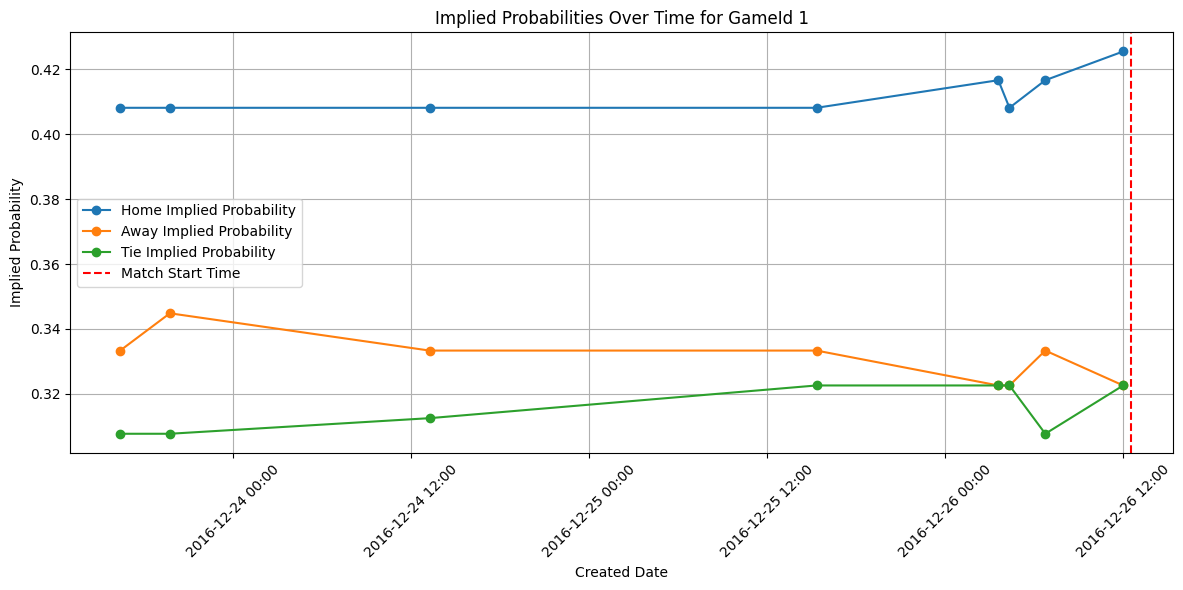

In [128]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

game1_df = sample

# Create a nice plot of the three implied probability columns versus the Created timestamp
plt.figure(figsize=(12, 6))

# Plot each probability vector with markers and labels
plt.plot(game1_df["date_created"], game1_df["home_implied_prob"], marker="o", label="Home Implied Probability")
plt.plot(game1_df["date_created"], game1_df["away_implied_prob"], marker="o", label="Away Implied Probability")
plt.plot(game1_df["date_created"], game1_df["tie_implied_prob"], marker="o", label="Tie Implied Probability")

# Set axis labels and title
plt.xlabel("Created Date")
plt.ylabel("Implied Probability")
plt.title(f"Implied Probabilities Over Time for GameId {game1_df['match_id'].iloc[0]}")

# Format the x-axis to show dates nicely
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)
plt.grid(True)

match_start_time = pd.to_datetime(game1_df["date_start"].iloc[0])
plt.axvline(x=match_start_time, color="red", linestyle="--", label="Match Start Time")



plt.legend()
plt.tight_layout()
plt.show()



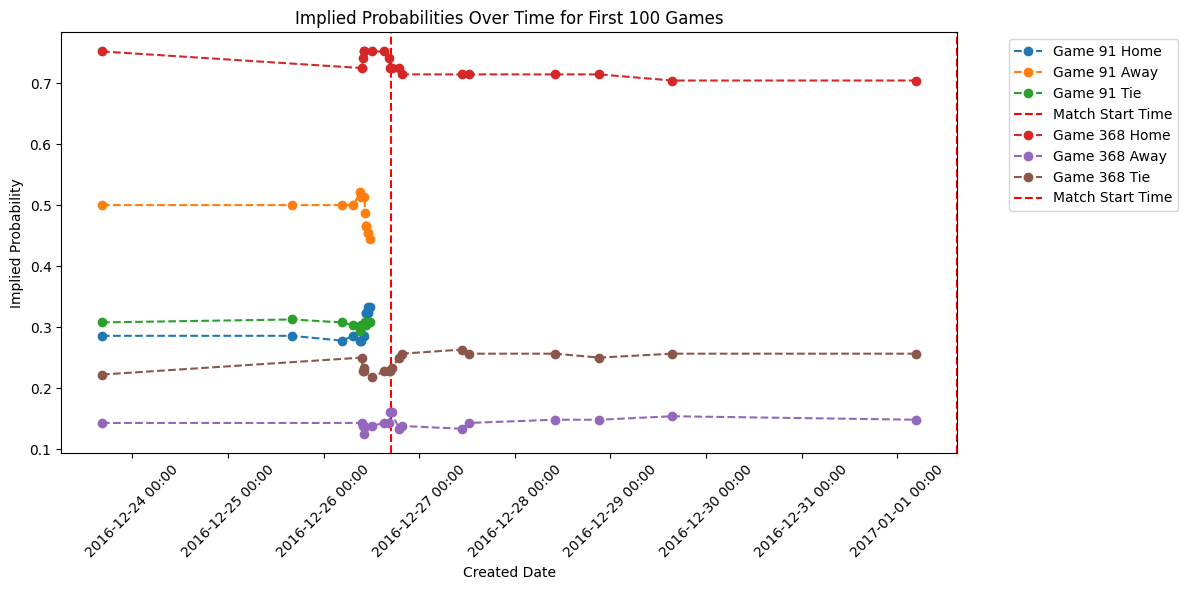

In [129]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Define how many games you want to plot (e.g., the first 100)
num_games_to_plot = 2
game_ids = list(match_time_series.keys())[:num_games_to_plot]

# Create one figure
plt.figure(figsize=(12, 6))

# Loop through each game ID and plot on the same figure
for game_id in game_ids:
    df_game = match_time_series[game_id].copy()
    df_game["Created"] = pd.to_datetime(df_game["date_created"])
    
    # Plot the home, away, and tie implied probability columns with a label including game id
    plt.plot(df_game["Created"], df_game["home_implied_prob"], marker="o", 
             linestyle="--", label=f"Game {game_id} Home")
    plt.plot(df_game["Created"], df_game["away_implied_prob"], marker="o", 
             linestyle="--", label=f"Game {game_id} Away")
    plt.plot(df_game["Created"], df_game["tie_implied_prob"], marker="o", 
             linestyle="--", label=f"Game {game_id} Tie")
    match_start_time = pd.to_datetime(df_game["date_start"].iloc[0])
    plt.axvline(x=match_start_time, color="red", linestyle="--", label="Match Start Time")

# Format the x-axis nicely for dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.xlabel("Created Date")
plt.ylabel("Implied Probability")
plt.title("Implied Probabilities Over Time for First 100 Games")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Put legend outside if it gets crowded
plt.tight_layout()
plt.show()


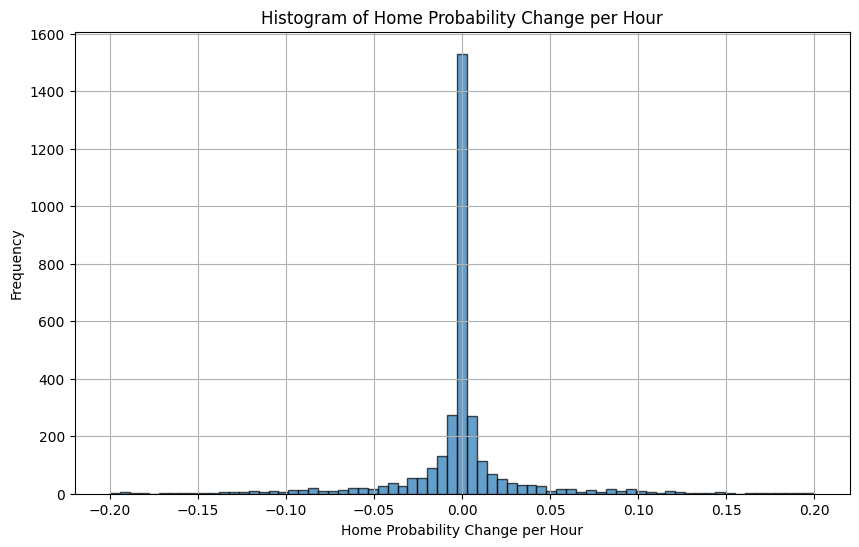

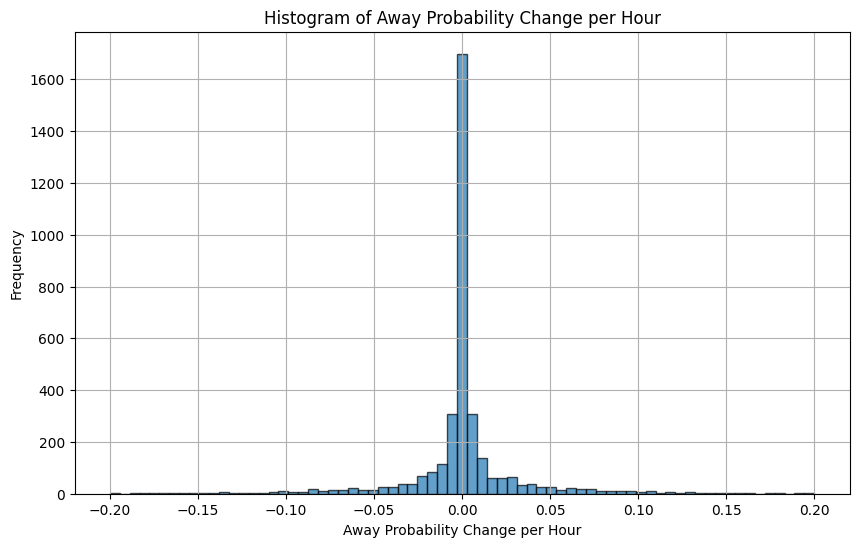

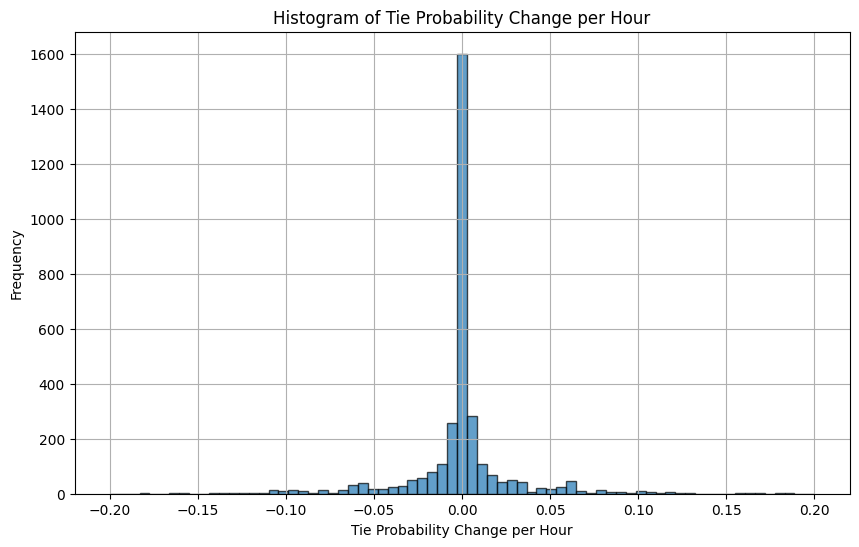

,match_id,date_start,competition_name,date_created,home_team_name,away_team_name,home_team_odd,away_team_odd,tie_odd,home_implied_prob,away_implied_prob,tie_implied_prob,time_delta_hours,home_diff,away_diff,tie_diff,home_change_per_hour,away_change_per_hour,tie_change_per_hour
2,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-24 13:15:00,Watford,Crystal Palace,2.45,3.0,3.20,0.408163,0.333333,0.312500,17.500000,0.000000,-0.011494,0.004808,0.000000,-0.000657,0.000275
3,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-25 15:20:00,Watford,Crystal Palace,2.45,3.0,3.10,0.408163,0.333333,0.322581,26.083333,0.000000,0.000000,0.010081,0.000000,0.000000,0.000386
6,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 06:45:00,Watford,Crystal Palace,2.40,3.0,3.25,0.416667,0.333333,0.307692,2.416667,0.008503,0.010753,-0.014888,0.003519,0.004449,-0.006161
7,1,2016-12-26 12:30:00,Eng. Premier League,2016-12-26 12:00:00,Watford,Crystal Palace,2.35,3.1,3.10,0.425532,0.322581,0.322581,5.250000,0.008865,-0.010753,0.014888,0.001689,-0.002048,0.002836
9,2,2016-12-26 15:00:00,Eng. Premier League,2016-12-25 11:45:00,Burnley,Middlesbrough,3.00,2.6,3.00,0.333333,0.384615,0.333333,43.350000,0.000000,-0.007541,0.010753,0.000000,-0.000174,0.000248


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Drop any NaN or infinite values before plotting to avoid errors or skewed histograms
df_clean = Eng_df.dropna(subset=["home_change_per_hour", "away_change_per_hour", "tie_change_per_hour"])
df_clean = df_clean[~df_clean["home_change_per_hour"].isin([float("inf"), float("-inf")])]
df_clean = df_clean[~df_clean["away_change_per_hour"].isin([float("inf"), float("-inf")])]
df_clean = df_clean[~df_clean["tie_change_per_hour"].isin([float("inf"), float("-inf")])]

# Histogram for home_change_per_hour with zoomed x-axis
plt.figure(figsize=(10, 6))
plt.hist(
    df_clean.loc[df_clean["home_change_per_hour"]!=0, "home_change_per_hour"],
    bins=71,
    range=(-.2, .2),  # sets the left and right edges of the histogram
    edgecolor="k",
    alpha=0.7
)
plt.xlabel("Home Probability Change per Hour")
plt.ylabel("Frequency")
plt.title("Histogram of Home Probability Change per Hour") # Zoom in on the x-axis from -0.2 to 0.2
plt.grid(True)
plt.show()

# Histogram for away_change_per_day with zoomed x-axis
plt.figure(figsize=(10, 6))
plt.hist(
    df_clean.loc[df_clean["away_change_per_hour"]!=0, "away_change_per_hour"],
    bins=71, # sets the left and right edges of the histogram
    edgecolor="k",
    range=(-.2, .2),
    alpha=0.7
)
plt.xlabel("Away Probability Change per Hour")
plt.ylabel("Frequency")
plt.title("Histogram of Away Probability Change per Hour")  # Adjust these limits as desired
plt.grid(True)
plt.show()

# Histogram for tie_change_per_day with zoomed x-axis
plt.figure(figsize=(10, 6))
# Let's say we only care about changes between -1.0 and 1.0 per day
plt.hist(
    df_clean.loc[df_clean["tie_change_per_hour"]!=0, "tie_change_per_hour"],
    bins=71,  # sets the left and right edges of the histogram
    edgecolor="k",
    range=(-.2, .2),
    alpha=0.7
)
plt.xlabel("Tie Probability Change per Hour")
plt.ylabel("Frequency")
plt.title("Histogram of Tie Probability Change per Hour")
  # Adjust as needed
plt.grid(True)
plt.show()


In [141]:
len(df['match_id'].unique())

32345

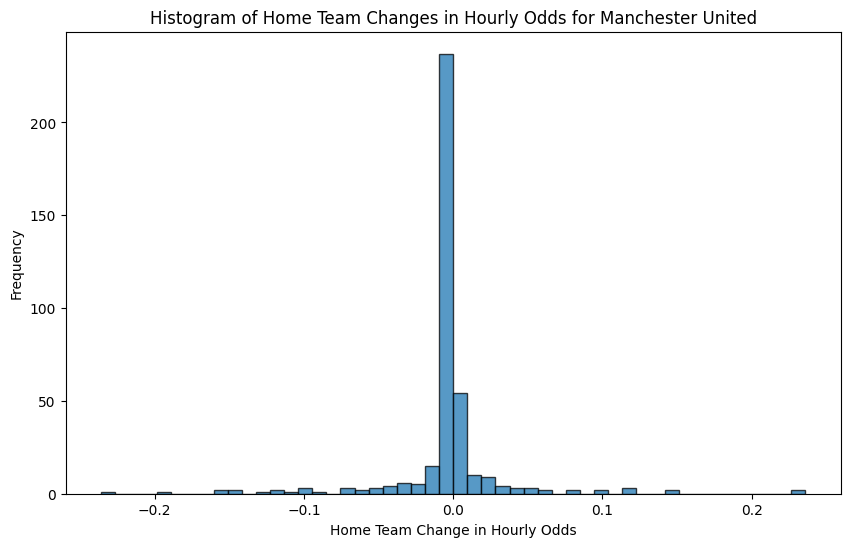

mean: -0.002103769410383181


In [143]:
df_man_utd = df[df["home_team_name"] == "Manchester United"].copy()

plt.figure(figsize=(10, 6))
plt.hist(df_man_utd["home_change_per_hour"].dropna(), bins=50, edgecolor="k", alpha=0.75)
plt.xlabel("Home Team Change in Hourly Odds")
plt.ylabel("Frequency")
plt.title("Histogram of Home Team Changes in Hourly Odds for Manchester United")
plt.show()

print(f"mean: {df_man_utd["home_change_per_hour"].dropna().mean()}")


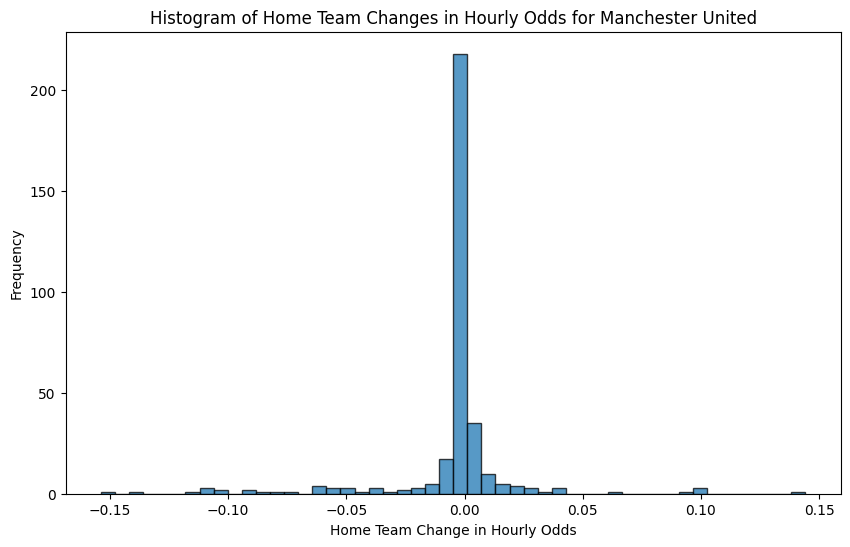

In [145]:
df_burnley = df[df["home_team_name"] == "Burnley"].copy()

plt.figure(figsize=(10, 6))
plt.hist(df_burnley["home_change_per_hour"].dropna(), bins=50, edgecolor="k", alpha=0.75)
plt.xlabel("Home Team Change in Hourly Odds")
plt.ylabel("Frequency")
plt.title("Histogram of Home Team Changes in Hourly Odds for Manchester United")
plt.show()

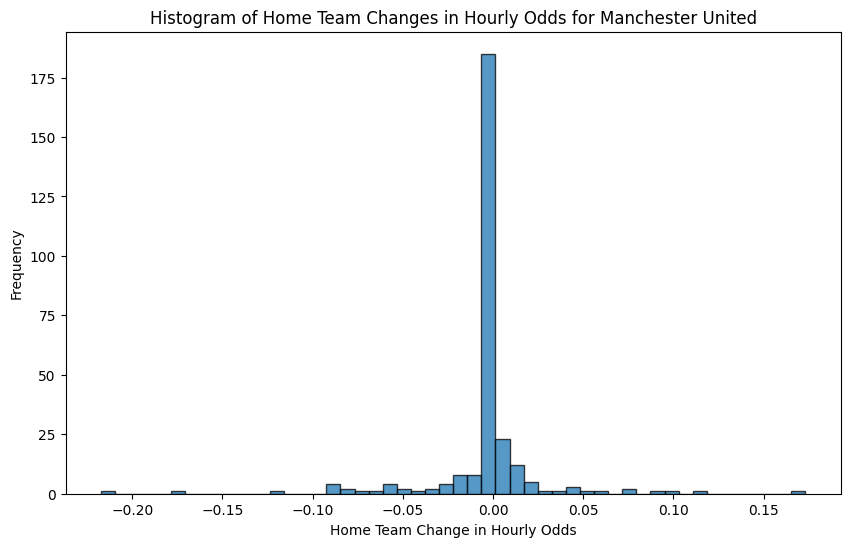

mean: -0.0024378404828101163
2511           NaN
2512     -0.000092
2513      0.000189
2514      0.091001
2515     -0.018121
            ...   
436074    0.000031
436075    0.000960
436076    0.000000
436077    0.000000
436078    0.097959
Name: home_change_per_hour, Length: 294, dtype: float64
294


In [146]:
df_burnley = df[df["away_team_name"] == "Burnley"].copy()

plt.figure(figsize=(10, 6))
plt.hist(df_burnley["home_change_per_hour"].dropna(), bins=50, edgecolor="k", alpha=0.75)
plt.xlabel("Home Team Change in Hourly Odds")
plt.ylabel("Frequency")
plt.title("Histogram of Home Team Changes in Hourly Odds for Manchester United")
plt.show()


print(f"mean: {df_burnley["home_change_per_hour"].dropna().mean()}")
print(df_burnley['home_change_per_hour'])
print(len(df_burnley['home_change_per_hour']))

ValueError: supplied range of [-inf, inf] is not finite

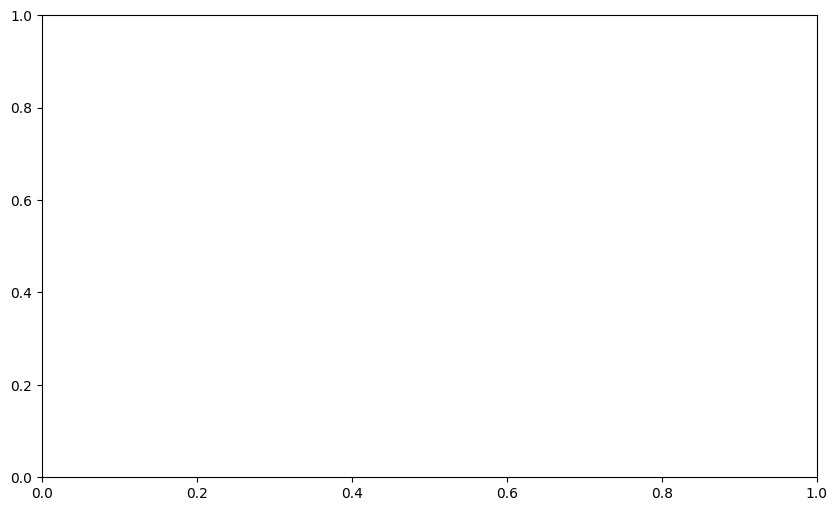

In [147]:
import scipy.stats as stats

df_nonzero_home = df[df["home_change_per_hour"] != 0].copy()

# Plot a histogram of the non-zero home_change_per_day values
plt.figure(figsize=(10, 6))
plt.hist(df_nonzero_home["home_change_per_hour"].dropna(), bins=201, edgecolor="k", alpha=0.7)
plt.xlabel("Home Probability Change per Hour (non-zero)")
plt.xlim(-5,5)
plt.ylabel("Frequency")
plt.title("Histogram of Non-Zero Home Probability Changes per Hour (Premier League)")
plt.grid(True)
plt.show()


print(f"mean: {df_nonzero_home["home_change_per_hour"].dropna().mean()}")

print(f"kurtosis: {stats.kurtosis(df_nonzero_home["home_change_per_hour"].dropna(), fisher=True)}")


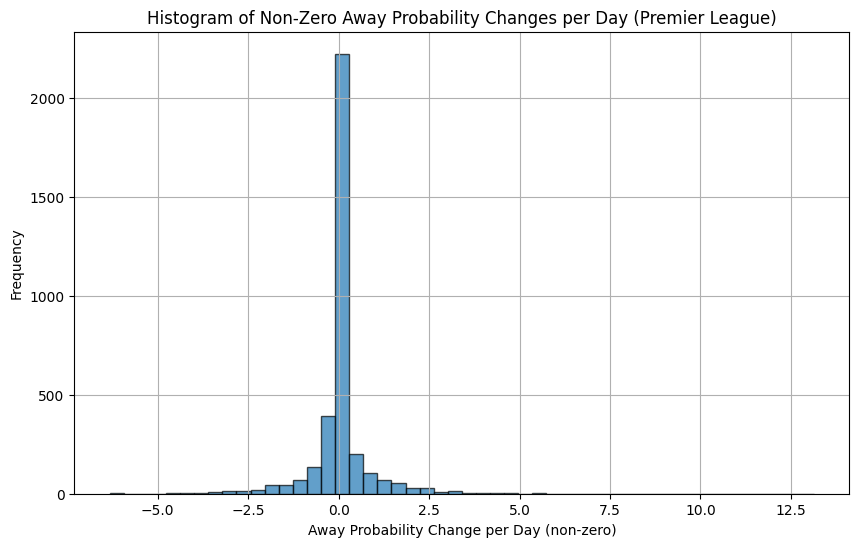

mean: 0.04698044898037387


In [111]:
df_nonzero_away = df[df["away_change_per_day"] != 0].copy()

plt.figure(figsize=(10, 6))
plt.hist(df_nonzero_away["away_change_per_day"].dropna(), bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Away Probability Change per Day (non-zero)")
plt.ylabel("Frequency")
plt.title("Histogram of Non-Zero Away Probability Changes per Day (Premier League)")
plt.grid(True)
plt.show()


print(f"mean: {df_nonzero_away["away_change_per_day"].dropna().mean()}")

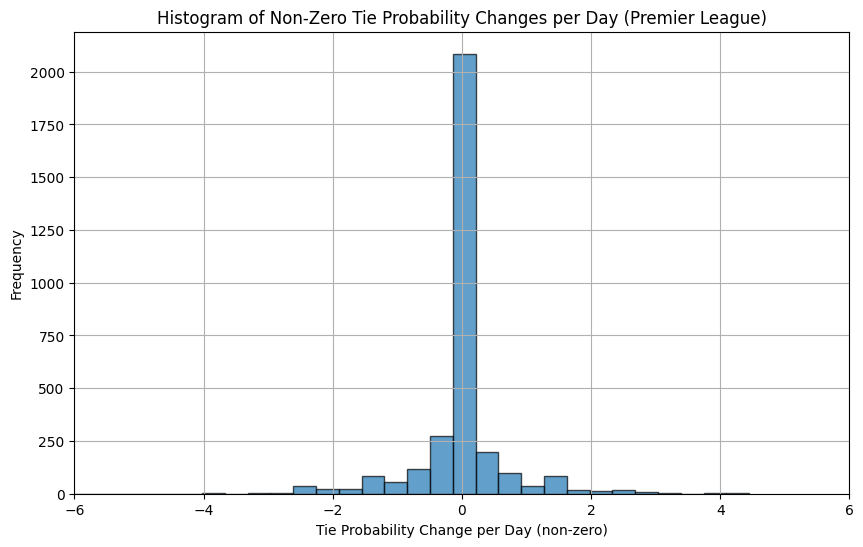

mean: -0.020235326363568364


In [110]:
df_nonzero_tie = df[df["tie_change_per_day"] != 0].copy()

plt.figure(figsize=(10, 6))
plt.hist(df_nonzero_tie["tie_change_per_day"].dropna(), bins=31, edgecolor="k", alpha=0.7)
plt.xlabel("Tie Probability Change per Day (non-zero)")
plt.xlim(-6,6)
plt.ylabel("Frequency")
plt.title("Histogram of Non-Zero Tie Probability Changes per Day (Premier League)")
plt.grid(True)
plt.show()

print(f"mean: {df_nonzero_tie["tie_change_per_day"].dropna().mean()}")